In [1]:
# import libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import numpy as np


from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

In [2]:
# Load the data
tensile_df =  pd.read_excel("../Tensile_Properties_Data.xlsx", header=0, skiprows=1)
tensile_df

,Reference,Material,Material Group,C (wt.%),Si (wt.%),Mn (wt.%),P (wt.%),S (wt.%),Ni (wt.%),Cr (wt.%),...,Width (mm),Aspect Ratio (L/W),Aspect Ratio (R/W),Aspect Ratio (T/W),Test Temperature (C),Strain Rate (1/s),Yield Strength (MPa),Ultimate Tensile Strength (MPa),Uniform Elongation (%),Total Elongation (%)
0,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,1.2,4.166700,1.1667,0.625000,23.0,0.001000,274.0,789.0,67.00,76.00
1,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,0.8,4.437500,0.3750,0.500000,23.0,0.001000,272.0,781.0,69.00,80.00
2,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,1.2,4.166700,1.1667,0.416667,23.0,0.001000,710.0,767.0,7.90,14.80
3,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,607.0,760.0,10.80,23.10
4,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,725.0,782.0,6.60,18.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,114.0,0.222807,NaN,0.114035,760.0,0.000067,214.0,572.0,59.35,67.66
1469,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.000067,207.0,494.0,38.80,47.80
1470,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.003667,101.0,352.0,31.22,47.25
1471,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,25.0,2.032000,NaN,0.000000,760.0,0.000067,177.0,497.0,40.40,46.50


In [3]:
# Check the data information for each column.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1210 non-null   object 
 4   Si (wt.%)                        1174 non-null   float64
 5   Mn (wt.%)                        1179 non-null   float64
 6   P (wt.%)                         1157 non-null   float64
 7   S (wt.%)                         965 non-null    float64
 8   Ni (wt.%)                        1387 non-null   float64
 9   Cr (wt.%)                        1404 non-null   float64
 10  Mo (wt.%)                        1331 non-null   float64
 11  Al (wt.%)                        484 non-null    float64
 12  N (wt.%)            

In [4]:
# Select the composition columns
compostion_cols = tensile_df.columns[3:29]
compostion_cols

Index(['C (wt.%)', 'Si (wt.%)', 'Mn (wt.%)', 'P (wt.%)', 'S (wt.%)',
       'Ni (wt.%)', 'Cr (wt.%)', 'Mo (wt.%)', 'Al (wt.%)', 'N (wt.%)',
       'Ti (wt.%)', 'Fe (wt.%)', 'Nb (wt.%)', 'B (wt.%)', 'Cu (wt.%)',
       'V (wt.%)', 'Mg (wt.%)', 'Y (wt.%)', 'Zr (wt.%)', 'Zn (wt.%)',
       'W (wt.%)', 'Sn (wt.%)', 'Co (wt.%)', 'O (wt.,%)', 'Ta (wt.%)',
       'H (wt.%)'],
      dtype='object')

In [5]:
# Fill the nan values with 0 for the comospition columns
tensile_df[compostion_cols]  = tensile_df[compostion_cols].fillna(0)

In [7]:
# Displace the unique values of the Zr, C and Fe compositions, 
# the initial data collection contains some < signs or ppm, bal, we want to check if these columns have this sign.
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 'bal' 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.09 0.21 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 '150-400ppm' '<40 ppm' 0.12 0.064 0.061 0.063 0.06
 0.05 0.04 0.058 0.009 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039
 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 90.174 96.828
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 0.165 '<0.6'
 99.19 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.15

In [8]:
# Remove the data with <, ppm and bal text in these there columns. 
tensile_df = tensile_df[~tensile_df['Zr (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['C (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['Fe (wt.%)'].isin(['<','ppm','bal'])]


In [9]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.09 0.21 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 0.12 0.064 0.061 0.063 0.06 0.05 0.04 0.058 0.009
 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 90.174 96.828
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 99.19
 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.1522 65.0159999999999 65.7088 64.6432 64.9213

In [10]:
# convert all of the composition columns' data type to float
tensile_df[compostion_cols]  = tensile_df[compostion_cols].astype(float)

In [12]:
# select the potential data for plot
tensile_df_plots = tensile_df[['Reference', 'Material','Gauge Length (mm)','Thickness (mm)','Width (mm)', 'Specimen Shape', 'Irradiation Dose (mdpa)', 'Specimen Size Type',
                               'Aspect Ratio (T/W)', 'Grain size (um)', 'Yield Strength (MPa)', 'Ultimate Tensile Strength (MPa)','Irradiation Temperature (C)',
                                'Uniform Elongation (%)', 'Total Elongation (%)' ]]

In [13]:
# Show the steel types:
tensile_df_plots['Material'].value_counts()

Material
SS316                                       527
JFMS                                        235
JPCA                                        186
SS316-A                                      95
SS316-B                                      72
SS316-C                                      71
SS316L                                       57
SA508-3                                      22
DC01                                         12
SS304                                        11
SA508 C1.3                                   11
CrMoV                                        11
DP600                                        10
DP800                                        10
FeCrAl                                        9
SS304LN                                       8
S235JR                                        8
S355JR                                        8
X5CrNi18-10                                   8
Ti6Al4V                                       8
20MnNiMo55                     

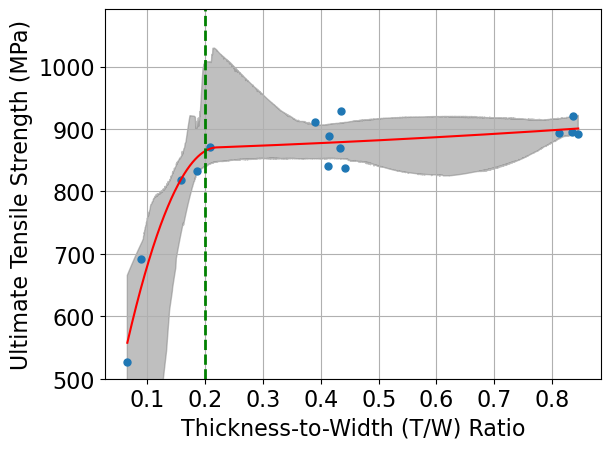

In [14]:
# Implement spline fitting for JPCA steel, show impact on ultimate tensile strength by width-to-thickness (T/W) ratio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample


tensile_df_plots_Flat_jpca = tensile_df_plots[(tensile_df_plots['Specimen Shape'] == 'Flat') & (tensile_df_plots['Material'].isin(['JPCA'])) 
                                              & (tensile_df_plots['Irradiation Dose (mdpa)'].isna())]

index_ids_to_remove = [74, 75, 76, 77,90, 94]

tensile_df_plots_Flat_jpca = tensile_df_plots_Flat_jpca.drop(index_ids_to_remove)


t_w_jpca = tensile_df_plots_Flat_jpca['Aspect Ratio (T/W)']
y_jpca = tensile_df_plots_Flat_jpca['Ultimate Tensile Strength (MPa)']


t_w_jpca = t_w_jpca[y_jpca.notna()]
y_jpca = y_jpca.dropna()


x = t_w_jpca.to_numpy()[:, np.newaxis]
y = y_jpca.to_numpy()

# Define knots for the spline
knots = np.array([0.001, 0.22, 0.90]).reshape(-1, 1)

# Create and fit the spline model
spline_transformer = SplineTransformer(degree=2, knots=knots)
model = make_pipeline(spline_transformer, LinearRegression())
model.fit(x, y)

# Create spline for plotting
x_spline = np.linspace(x.min(), x.max(), 3000)
x_spline = x_spline[:, np.newaxis]
y_spline = model.predict(x_spline)

# Number of bootstrap samples
n_bootstrap = 1000
bootstrapped_fits = []

# Bootstrap resampling loop
for _ in range(n_bootstrap):
    # Resample the data
    x_resampled, y_resampled = resample(x, y)
    
    # Fit the pipeline to the resampled data
    model.fit(x_resampled, y_resampled)
    
    # Evaluate the model on the spline x values and store the result
    y_resampled_fit = model.predict(x_spline)
    bootstrapped_fits.append(y_resampled_fit)

# Convert the list of bootstrap fits to a NumPy array for easier manipulation
fits_array = np.array(bootstrapped_fits)

# Calculate the mean and confidence intervals
fit_mean = np.mean(fits_array, axis=0)
fit_lower = np.percentile(fits_array, 2.5, axis=0)
fit_upper = np.percentile(fits_array, 97.5, axis=0)

# Plot the original data and the spline fit
plt.plot(x, y, 'o', markersize=5)
plt.plot(x_spline, y_spline, 'r-')

# Plot the confidence interval
plt.fill_between(x_spline.ravel(), fit_lower, fit_upper, color='gray', alpha=0.5)

plt.xlabel('Thickness-to-Width (T/W) Ratio', fontsize=16)
plt.ylabel('Ultimate Tensile Strength (MPa)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(x=0.2, color='g', linestyle='--', linewidth=2)
plt.ylim(bottom = 500)
# Add grid to the plotl
plt.grid(True)

plt.show()



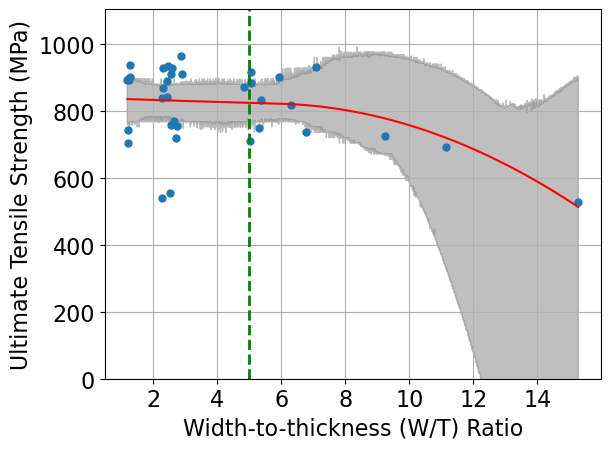

In [13]:
# Implement spline fitting for JPCA steel, show impact on ultimate tensile strength by width-to-thickness (W/T) ratio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample



tensile_df_plots_Flat_jpca = tensile_df_plots[(tensile_df_plots['Specimen Shape'] == 'Flat') & (tensile_df_plots['Material'].isin(['JPCA'])) 
                                              ]

index_ids_to_remove = [74, 75, 76, 77,90,91, 94]

tensile_df_plots_Flat_jpca = tensile_df_plots_Flat_jpca.drop(index_ids_to_remove)

w_t_jpca = 1/tensile_df_plots_Flat_jpca['Aspect Ratio (T/W)']
y_jpca = tensile_df_plots_Flat_jpca['Ultimate Tensile Strength (MPa)']

w_t_jpca = w_t_jpca[y_jpca.notna()]
y_jpca = y_jpca.dropna()


x = w_t_jpca.to_numpy()[:, np.newaxis]
y = y_jpca.to_numpy()

# Define knots for the spline
knots = np.array([0.3, 5.9, 17]).reshape(-1, 1)

# Create and fit the spline model
spline_transformer = SplineTransformer(degree=2, knots=knots)
model = make_pipeline(spline_transformer, LinearRegression())
model.fit(x, y)

# Create spline for plotting
x_spline = np.linspace(x.min(), x.max(), 3000)
x_spline = x_spline[:, np.newaxis]
y_spline = model.predict(x_spline)

# Number of bootstrap samples
n_bootstrap = 1000
bootstrapped_fits = []

# Bootstrap resampling loop
for _ in range(n_bootstrap):
    # Resample the data
    x_resampled, y_resampled = resample(x, y)
    
    # Fit the pipeline to the resampled data
    model.fit(x_resampled, y_resampled)
    
    # Evaluate the model on the spline x values and store the result
    y_resampled_fit = model.predict(x_spline)
    bootstrapped_fits.append(y_resampled_fit)

# Convert the list of bootstrap fits to a NumPy array for easier manipulation
fits_array = np.array(bootstrapped_fits)

# Calculate the mean and confidence intervals
fit_mean = np.mean(fits_array, axis=0)
fit_lower = np.percentile(fits_array, 2.5, axis=0)
fit_upper = np.percentile(fits_array, 97.5, axis=0)

# Plot the original data and the spline fit
plt.plot(x, y, 'o', markersize=5)
plt.plot(x_spline, y_spline, 'r-')

# Plot the confidence interval
plt.fill_between(x_spline.ravel(), fit_lower, fit_upper, color='gray', alpha=0.5)

plt.xlabel('Width-to-thickness (W/T) Ratio', fontsize=16)
plt.ylabel('Ultimate Tensile Strength (MPa)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(x=5, color='g', linestyle='--', linewidth=2)
plt.ylim(bottom = 0)
# Add grid to the plotl
plt.grid(True)

plt.show()



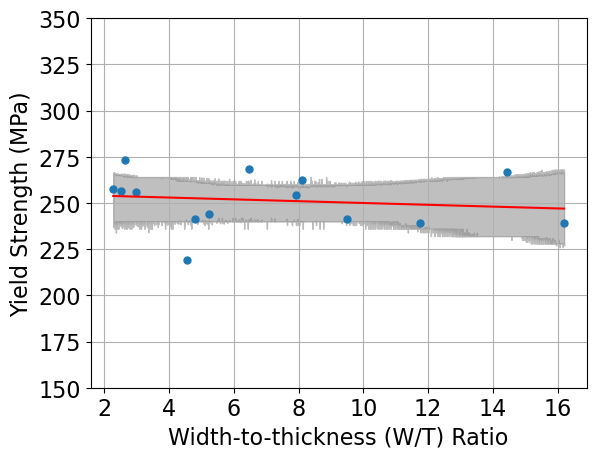

In [ ]:
# Implement spline fitting for JPCA steel, show impact on YS  by width-to-thickness (W/T) ratio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample



tensile_df_plots_Flat_jpca = tensile_df_plots[(tensile_df_plots['Specimen Shape'] == 'Flat') & (tensile_df_plots['Material'].isin(['JPCA'])) 
                                             & (tensile_df_plots['Irradiation Dose (mdpa)'].isna() ) ]

## remove two outline data points
index_ids_to_remove = [57,64, 66]
tensile_df_plots_Flat_jpca = tensile_df_plots_Flat_jpca.drop(index_ids_to_remove)



w_t_jpca = 1/tensile_df_plots_Flat_jpca['Aspect Ratio (T/W)']
y_jpca = tensile_df_plots_Flat_jpca['Yield Strength (MPa)']

w_t_jpca = w_t_jpca[y_jpca.notna()]
y_jpca = y_jpca.dropna()


x = w_t_jpca.to_numpy()[:, np.newaxis]
y = y_jpca.to_numpy()

# Define knots for the spline
knots = np.array([0.3, 25]).reshape(-1, 1)

# Create and fit the spline model
spline_transformer = SplineTransformer(degree=1, knots=knots)
model = make_pipeline(spline_transformer, LinearRegression())
model.fit(x, y)

# Create spline for plotting
x_spline = np.linspace(x.min(), x.max(), 3000)
x_spline = x_spline[:, np.newaxis]
y_spline = model.predict(x_spline)

# Number of bootstrap samples
n_bootstrap = 1000
bootstrapped_fits = []

# Bootstrap resampling loop
for _ in range(n_bootstrap):
    # Resample the data
    x_resampled, y_resampled = resample(x, y)
    
    # Fit the pipeline to the resampled data
    model.fit(x_resampled, y_resampled)
    
    # Evaluate the model on the spline x values and store the result
    y_resampled_fit = model.predict(x_spline)
    bootstrapped_fits.append(y_resampled_fit)

# Convert the list of bootstrap fits to a NumPy array for easier manipulation
fits_array = np.array(bootstrapped_fits)

# Calculate the mean and confidence intervals
fit_mean = np.mean(fits_array, axis=0)
fit_lower = np.percentile(fits_array, 2.5, axis=0)
fit_upper = np.percentile(fits_array, 97.5, axis=0)

# Plot the original data and the spline fit
plt.plot(x, y, 'o', markersize=5)
plt.plot(x_spline, y_spline, 'r-')

# Plot the confidence interval
plt.fill_between(x_spline.ravel(), fit_lower, fit_upper, color='gray', alpha=0.5)


plt.xlabel('Width-to-thickness (W/T) Ratio', fontsize=16)
plt.ylabel('Yield Strength (MPa)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(150, 350)
# Add grid to the plotl
plt.grid(True)

plt.show()



0
12
24


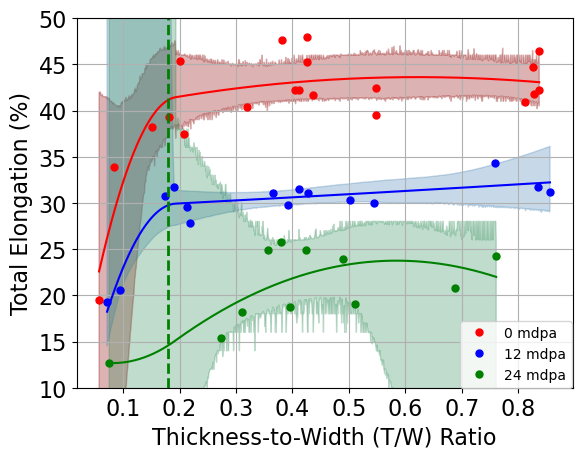

In [15]:
# Implement spline fitting for JPCA steel, show impact of irradiation dose and thickness-to-width (T/W) ratio on total elongation.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def plot_fit_curve(x, y, color, label, mat):


    x = x.to_numpy()[:, np.newaxis]
    y = y.to_numpy()


    
    knots = np.array([0.001,  0.193, 0.95]).reshape(-1, 1)

    spline_transformer = SplineTransformer(degree=2, knots=knots)
    model = make_pipeline(spline_transformer, LinearRegression())
    model.fit(x, y)

    # Generate points to plot the fitted spline
    x_spline = np.linspace(x.min(), x.max(), 1000)
    x_spline = x_spline[:, np.newaxis]
    y_spline = model.predict(x_spline)


    # Number of bootstrap samples
    n_bootstrap = 30000
    bootstrapped_fits = []

    # Bootstrap resampling loop
    for _ in range(n_bootstrap):
        # Resample the data
        x_resampled, y_resampled = resample(x, y)
        
        # Fit the pipeline to the resampled data
        model.fit(x_resampled, y_resampled)
        
        # Evaluate the model on the spline x values and store the result
        y_resampled_fit = model.predict(x_spline)
        bootstrapped_fits.append(y_resampled_fit)

    # Convert the list of bootstrap fits to a NumPy array for easier manipulation
    fits_array = np.array(bootstrapped_fits)

    # Calculate the mean and confidence intervals
    fit_mean = np.mean(fits_array, axis=0)
    fit_lower = np.percentile(fits_array, 2.5, axis=0)
    fit_upper = np.percentile(fits_array, 97.5, axis=0)

    # Plot the original data and the spline fit
    plt.plot(x, y, 'o', markersize=5, c=color, label=str(label) + ' mdpa')
    plt.plot(x_spline, y_spline, color[0]+'-')

    # # Plot the confidence interval
    if color== 'green':
        fill_color = 'seagreen'
    elif color == 'blue':
        fill_color = 'steelblue'
    elif color == 'red':
        fill_color = 'darkred'
    plt.fill_between(x_spline.ravel(), fit_lower, fit_upper, color=fill_color, alpha=0.3)


color_map = {0: 'red', 12: 'blue', 24:'green'}

# JPCA data

tensile_df_plots_Flat_jpca = tensile_df_plots[(tensile_df_plots['Specimen Shape'] == 'Flat') 
                                              & (tensile_df_plots['Material'].isin(['JPCA'])) & (tensile_df_plots['Irradiation Dose (mdpa)'].notna()) 
                                            & (tensile_df_plots['Irradiation Dose (mdpa)'] <= 24) & (tensile_df_plots['Irradiation Temperature (C)'] == 157) ]


# index_ids_to_remove = [277, 282, 289]
# tensile_df_plots_Flat_jpca = tensile_df_plots_Flat_jpca.drop(index_ids_to_remove)



w_t = tensile_df_plots_Flat_jpca['Aspect Ratio (T/W)']
y = tensile_df_plots_Flat_jpca['Total Elongation (%)']

# Group the data by irradiation
c_Flat_jpca = tensile_df_plots_Flat_jpca['Irradiation Dose (mdpa)'][y.notna()]
x = w_t[y.notna()]
y = y.dropna()

df = pd.DataFrame({'x': x, 'y': y, 'label':c_Flat_jpca })


for label, color in color_map.items():
    subset = df[df['label'] == label]
    # plt.scatter(subset['x'], subset['y'], c=color, label=str(label) + ' mdpa', s=20, marker= 's')
    x =  subset['x']
    y = subset['y']
    mat = 'JPCA'
    print(label)

    plot_fit_curve(x, y, color, label, mat)


plt.ylim(10, 50)

plt.xlabel('Thickness-to-Width (T/W) Ratio', fontsize=16)
plt.ylabel('Total Elongation (%)', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.legend(loc=(0.773, 0))

plt.axvline(x=0.18, color='g', linestyle='--', linewidth=2)